In [147]:
# Maths and data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import minmax_scale

# For the neural network (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

# Implementing neural network model
from sklearn.model_selection import train_test_split


##### **Parameters**

In [148]:
random = 101 # Random seed for reproducibility

np.random.seed(random)
torch.manual_seed(random)

# Neural network parameters
hidden_layers = 1 # Number of hidden layers

# Training parameters
learning_rate = 0.01
weight_decay = 0.001 # This corresponds to the L2 regularisation in PyTorch
epochs = 400 # Number of epochs for training
pca_on = True

##### **Pre-processing**

In [149]:
df_all = pd.read_excel('./TrainDataset2023.xls')

# Drop the first column from the DataFrame
df_all.drop(df_all.columns[:1], axis=1, inplace=True)
df_all.drop('RelapseFreeSurvival (outcome)', axis=1, inplace=True)

# Remove rows which have pCR (outcome) as 999
df_all = df_all[df_all['pCR (outcome)'] != 999]

In [150]:
#for column 12 and onwards
cols = df_all.columns[12:]
#clip outliers in the 99th percentile
df_all[cols] = df_all[cols].clip(upper=df_all[cols].quantile(0.99), axis=1)

#min max scaling for mri values only
cols = df_all.columns[12:]
df_all[cols] = (df_all[cols] - df_all[cols].min()) / (df_all[cols].max() - df_all[cols].min())

# normalise these values using the standard scaler
cols = df_all.columns[12:]
scaler = StandardScaler()
df_all[cols] = scaler.fit_transform(df_all[cols])

In [151]:
# Split the dataset into training and testing data
X = df_all.drop('pCR (outcome)', axis=1)
y = df_all['pCR (outcome)']

if pca_on:
    # PCA
    pca = PCA(n_components=0.95)
    pca.fit_transform(X)

In [152]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random)


# Convert the data into tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Get the number of input features
input_features = X_train.shape[1]

##### **Model**

In [154]:
class ANN(nn.Module):
    def __init__(self, input_features, hidden1=hidden_layers, out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features, hidden1)
        self.out = nn.Linear(hidden1, out_features)

    def forward(self, x):
        x = self.f_connected1(x)
        x = F.sigmoid(x)
        x = self.out(x)
        return x

##### **Training**

Text(0, 0.5, 'Loss')

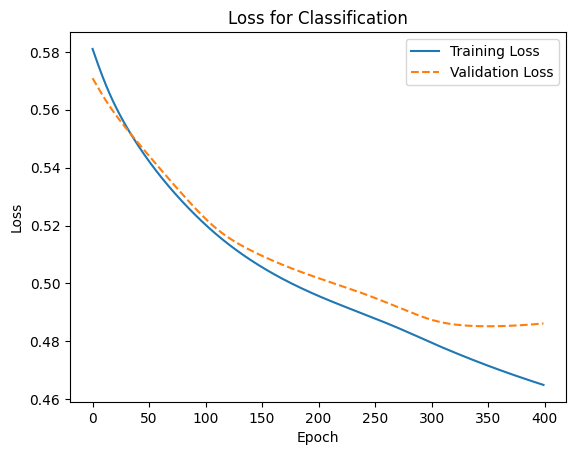

In [155]:
model =  ANN(input_features)

# Split trainining data into training and validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=random)

losses = []
val_losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

for i in range(epochs):
    y_pred = model.forward(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    with torch.no_grad():
        y_val_pred = model.forward(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

# Plot the loss
plt.plot(range(epochs), losses, label="Training Loss")

# Plot the validation set
plt.plot(range(epochs), val_losses, label="Validation Loss", linestyle='dashed')

# Show legend
plt.legend()

plt.title('Loss for Classification')
plt.xlabel("Epoch")
plt.ylabel("Loss")


##### **Model Output on Test File**

In [156]:
output = pd.read_excel('./TestDatasetExample.xls')
# output_id is equal to the ID column of the output DataFrame
output_id = output['ID']
output.drop('ID', axis=1, inplace=True)

imputer = SimpleImputer(missing_values = 999, strategy="median") 
SimpleImputer(missing_values = 999)
s = 0
for i in output:
    imputer.fit(output)
    array = np.array(output[i])
    output[i] = imputer.fit_transform(array.reshape(-1, 1))  

In [157]:
colno = 0
for col in output:
    if colno >= 9:
        colmed = np.median(output[col])
        colstd = np.std(output[col])
        upper = colmed + (3*colstd)
        lower = colmed - (3*colstd)

        output[col] = minmax_scale(output[col], feature_range=(lower,upper)) #Minimal Change - Downscales severity of Mean Squared Error
    colno+=1

In [158]:
if pca_on:
    # PCA
    pca = PCA(n_components=0.95)
    pca.fit_transform(output)

In [159]:
scaler = StandardScaler()
Xs = scaler.fit_transform(output)

model.eval()
with torch.no_grad():
    y_pred = model(torch.FloatTensor(Xs))
    _, predicted = torch.max(y_pred, 1)

In [160]:
#Cast ID and predicted Y value into new list to export to an output csv
idlist = []
# for i in the second column of the output_id dataframe
for i in output_id:
    idlist.append(i)   
ylist = []
for i in predicted:
    ylist.append(i.item())

print(idlist)
print(ylist)

['TRG002728', 'TRG002649', 'TRG002628']
[0, 0, 0]


In [161]:
#Export Patient ID and Predicted RFS to Specified Sheet (MUST BE CSV)
write = pd.DataFrame({
    'ID': idlist, 
    'pCR (outcome)': ylist
})

write.to_csv('COMP4139 Regression Test Result Export.csv', index = False)